In [1]:
pip install image_similarity_measures

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
     |████████████████████████████████| 19.3 MB 127 kB/s 
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26983 sha256=033c4a221077cd6e4af838acc1fce52e4d472af0983b57705de07c910d08f981
  Stored in directory: /root/.cache/pip/wheels/39/5c/b3/79292d7ac3f088e858805b5515b45cf5a365106397d936caf1
Successfully built phasepack


In [2]:
from keras.datasets import mnist, cifar10
from keras.models import Sequential, load_model
from keras.layers.core import Activation
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from time import time
import cv2
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras import backend as K 
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre, issm, sam, uiq, fsim, psnr

np.random.seed(100)

In [3]:
def preprocess(dataset='mnist'):
  if (dataset == 'mnist'):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  else:
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  return (X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten)


In [4]:
class Fuzzer:
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    self.model = model
    self.modelType = modelType
    self.epsilon = epsilon
    self.image = image
    self.flattenImage = self.image.flatten()
    self.imageShape = self.image.shape
    self.imageFlattenedShape = self.flattenImage.shape
    self.modifiedImage = self.image
    self.modifiedFlattenImage = self.flattenImage
    self.imageLabel = imageLabel
    self.time = 0
    self.t1 = 0
    self.t2 = 0
    self.dataset = dataset

  def randomDirection(self):
    pass 

  def generate(self):
    self.t1 = time()
    for i in (range(50000)):
      self.randomDirection()
      if self.modelType == 'ANN':
        if self.dataset == 'mnist':
          newID = np.argmax(self.model.predict(self.modifiedFlattenImage.reshape(-1, 784)))
        else:
          newID = np.argmax(self.model.predict(self.modifiedFlattenImage.reshape(-1, 3072)))
        oldID = np.argmax(self.imageLabel)
      else:
        if self.dataset == 'cifar10':
          sh = (1, 32, 32, 3)
        else:
          sh = (1, 28, 28, 1)
        newID = np.argmax(self.model.predict(np.reshape(self.modifiedImage, newshape=sh)))
        oldID = np.argmax(self.imageLabel)
      if (newID != oldID):
        print(f'We found it in iteration number {i}')
        print(f"new ID: {newID}")
        print(f"old ID: {oldID}")
      
        self.t2 = time()
        self.time= self.t2 - self.t1
        break
  def plot(self, fuzzerName):
    fig = plt.figure()
    fig.suptitle(f"{fuzzerName}", fontsize=16)
    plt.subplot(1,2,1)
    plt.tight_layout()
    plt.imshow(self.modifiedImage)
    plt.title(f"My new distorted picture")
    plt.subplot(1,2,2)
    plt.tight_layout()
    plt.imshow(self.image)
    plt.title(f"My original picture")


class CompeletlyRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.randint(-1, 2, self.imageFlattenedShape)
    self.modifiedFlattenImage += self.epsilon * vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)

class laplaceRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.laplace(0, self.epsilon, self.imageFlattenedShape)
    self.modifiedFlattenImage += vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)

class normalRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.normal(0, self.epsilon, self.imageFlattenedShape)
    self.modifiedFlattenImage += vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)

class gumbelRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.gumbel(0, self.epsilon, self.imageFlattenedShape)
    self.modifiedFlattenImage += vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)


class CompeletlyRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset =dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.randint(-1, 2, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += self.epsilon * vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break
  

class laplaceRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.laplace(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class normalRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.normal(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class gumbelRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset= dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.gumbel(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

#####

class CompeletlyRandomISSM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset =dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.randint(-1, 2, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += self.epsilon * vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = issm(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break
  

class laplaceRandomISSM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.laplace(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = issm(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class normalRandomISSM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.normal(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = issm(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class gumbelRandomISSM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset= dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.gumbel(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = issm(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

In [5]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('mnist')

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
model_mnist_ann = load_model("model_mnist_ann.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 26
new ID: 8
old ID: 7
It took us 2.343785047531128 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 267
new ID: 8
old ID: 7
It took us 9.836107015609741 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 141
new ID: 8
old ID: 7
It took us 5.060570478439331 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 311
new ID: 8
old ID: 7
It took us 11.653993606567383 seconds
-------------------------------------------------------


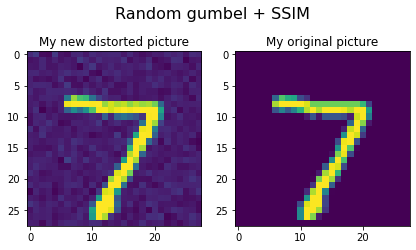

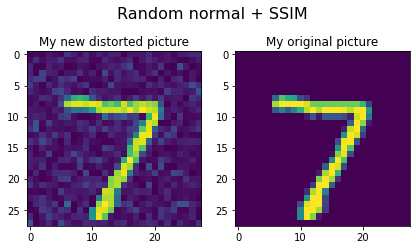

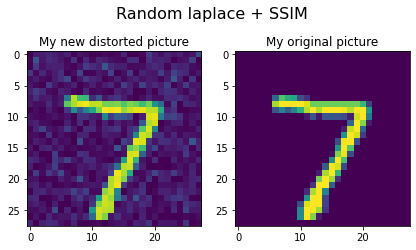

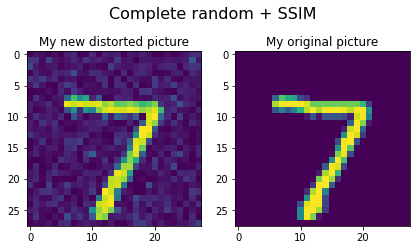

In [8]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

In [9]:
model_mnist_cnn = load_model("model_mnist_cnn.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 53
new ID: 8
old ID: 7
It took us 14.80630874633789 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 746
new ID: 8
old ID: 7
It took us 29.813087940216064 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 416
new ID: 8
old ID: 7
It took us 16.019890785217285 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 773
new ID: 8
old ID: 7
It took us 31.528857469558716 seconds
-------------------------------------------------------


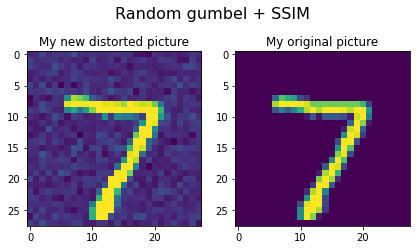

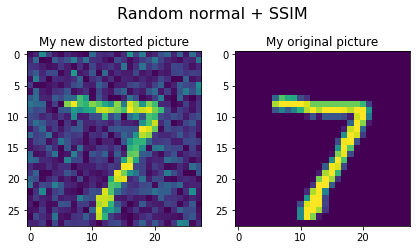

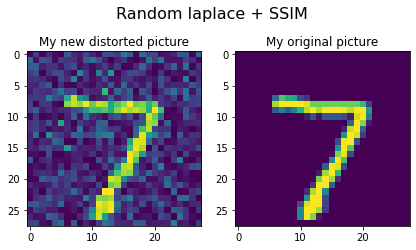

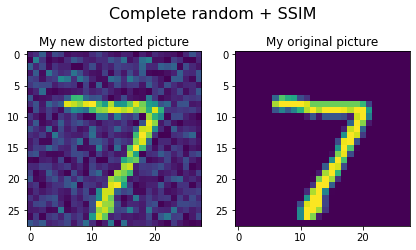

In [10]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

Gumbel random fuzzer + ISSM:


/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:163: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


We found it in iteration number 51
new ID: 8
old ID: 7
It took us 1.945152997970581 seconds
-------------------------------------------------------
Normal random fuzzer + ISSM:
We found it in iteration number 971
new ID: 0
old ID: 7
It took us 35.49058651924133 seconds
-------------------------------------------------------
Laplace random fuzzer + ISSM:
We found it in iteration number 402
new ID: 8
old ID: 7
It took us 14.82627248764038 seconds
-------------------------------------------------------
Compeletly random fuzzer + ISSM:
We found it in iteration number 1794
new ID: 8
old ID: 7
It took us 65.6065263748169 seconds
-------------------------------------------------------


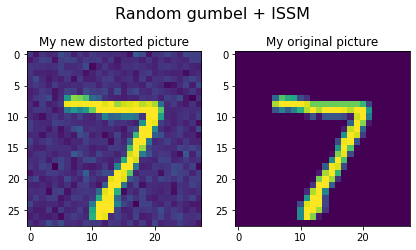

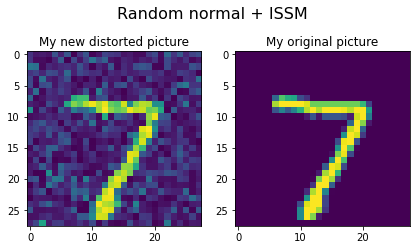

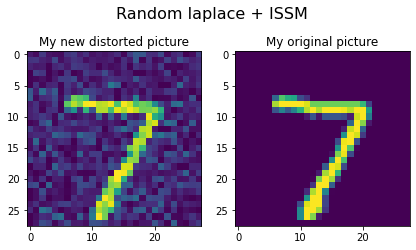

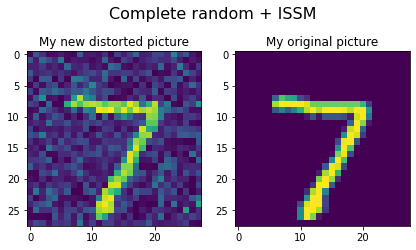

In [11]:
print("Gumbel random fuzzer + ISSM:")
myFuzz = gumbelRandomISSM(0.005, X_test[0], y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + ISSM")
print("-------------------------------------------------------")
print("Normal random fuzzer + ISSM:")
myFuzz = normalRandomISSM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + ISSM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + ISSM:")
myFuzz = laplaceRandomISSM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + ISSM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + ISSM:")
myFuzz = CompeletlyRandomISSM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + ISSM")
print("-------------------------------------------------------")

In [12]:
model_mnist_ann = load_model("model_mnist_ann.h5")

Gumbel random fuzzer + ISSM:


/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:163: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


We found it in iteration number 28
new ID: 8
old ID: 7
It took us 1.1254663467407227 seconds
-------------------------------------------------------
Normal random fuzzer + ISSM:
We found it in iteration number 358
new ID: 8
old ID: 7
It took us 13.069298267364502 seconds
-------------------------------------------------------
Laplace random fuzzer + ISSM:
We found it in iteration number 201
new ID: 8
old ID: 7
It took us 7.2591893672943115 seconds
-------------------------------------------------------
Compeletly random fuzzer + ISSM:
We found it in iteration number 519
new ID: 8
old ID: 7
It took us 18.942270278930664 seconds
-------------------------------------------------------


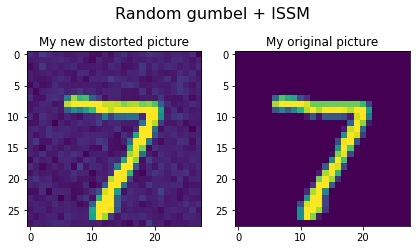

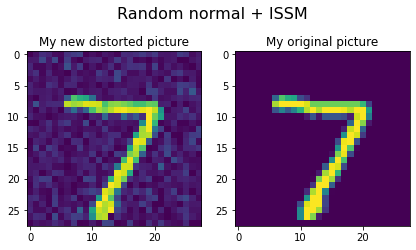

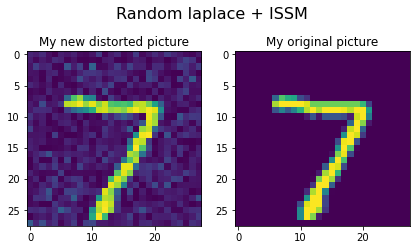

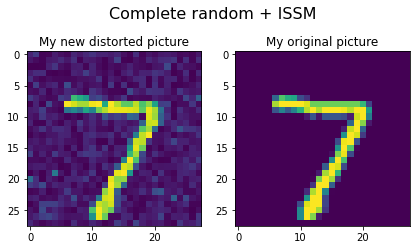

In [13]:
print("Gumbel random fuzzer + ISSM:")
myFuzz = gumbelRandomISSM(0.005, X_test[0], y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + ISSM")
print("-------------------------------------------------------")
print("Normal random fuzzer + ISSM:")
myFuzz = normalRandomISSM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + ISSM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + ISSM:")
myFuzz = laplaceRandomISSM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + ISSM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + ISSM:")
myFuzz = CompeletlyRandomISSM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + ISSM")
print("-------------------------------------------------------")

In [14]:
model_mnist_ann = load_model("model_mnist_ann.h5")

Gumbel random fuzzer:
We found it in iteration number 25
new ID: 8
old ID: 7
It took us 1.0632925033569336 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 298
new ID: 8
old ID: 7
It took us 9.05624532699585 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 165
new ID: 8
old ID: 7
It took us 4.972747087478638 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 420
new ID: 8
old ID: 7
It took us 12.922598361968994 seconds
-------------------------------------------------------


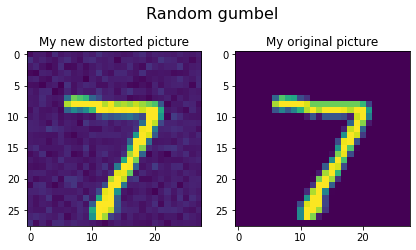

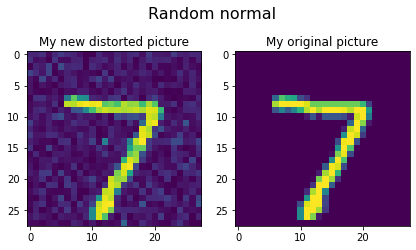

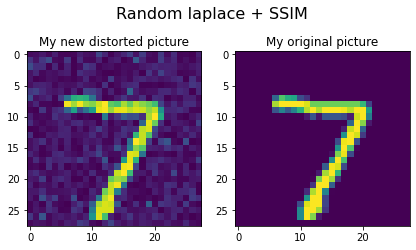

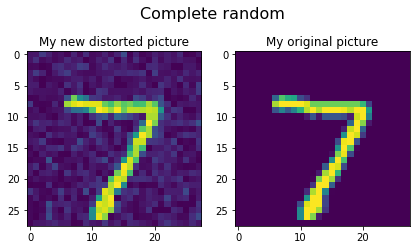

In [15]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

Gumbel random fuzzer:
We found it in iteration number 52
new ID: 8
old ID: 7
It took us 1.642002820968628 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 906
new ID: 8
old ID: 7
It took us 28.152400493621826 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 499
new ID: 8
old ID: 7
It took us 15.576968431472778 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 1693
new ID: 8
old ID: 7
It took us 52.3344042301178 seconds
-------------------------------------------------------


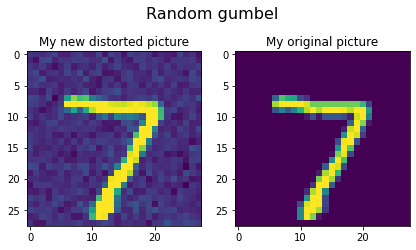

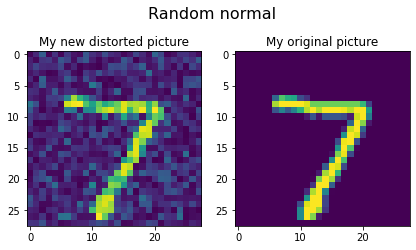

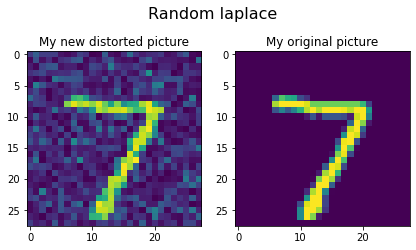

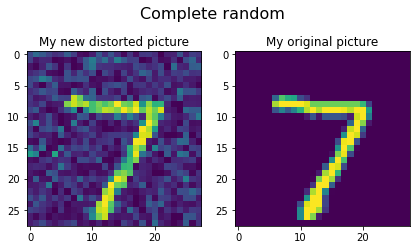

In [16]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

In [17]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('cifar10')

170508288/170498071 [==============================] - 11s 0us/step


In [18]:
model_cifar_ann = load_model("model_cifar_ann.h5")

Gumbel random fuzzer:
We found it in iteration number 93
new ID: 5
old ID: 3
It took us 2.997246503829956 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 1352
new ID: 4
old ID: 3
It took us 41.4493567943573 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 2665
new ID: 8
old ID: 3
It took us 81.57202434539795 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 7158
new ID: 4
old ID: 3
It took us 219.02642226219177 seconds
-------------------------------------------------------


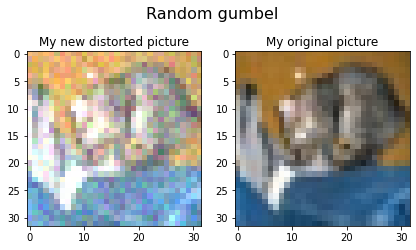

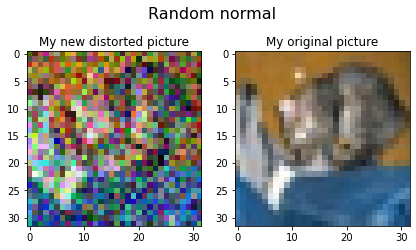

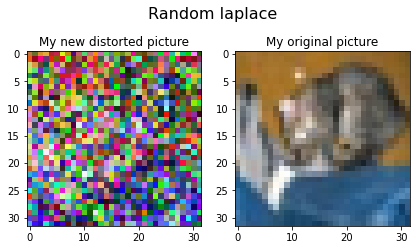

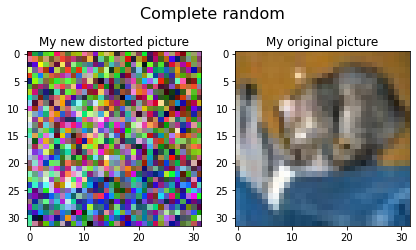

In [19]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

In [21]:
model_cifar_cnn = load_model("model_cifar_cnn.h5")

Gumbel random fuzzer:
We found it in iteration number 40
new ID: 2
old ID: 3
It took us 1.4572532176971436 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 71
new ID: 6
old ID: 3
It took us 2.2524256706237793 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 27
new ID: 2
old ID: 3
It took us 0.8755755424499512 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 95
new ID: 2
old ID: 3
It took us 3.1774747371673584 seconds
-------------------------------------------------------


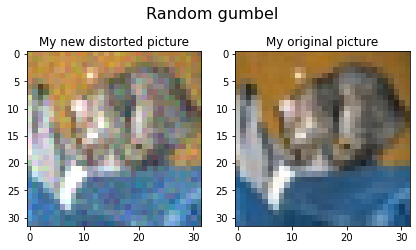

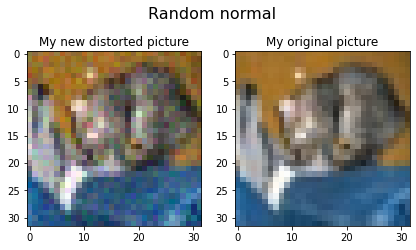

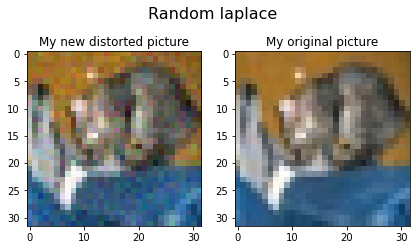

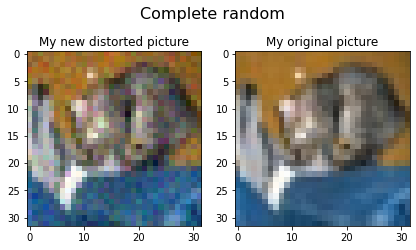

In [22]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

Gumbel random fuzzer + SSIM:
We found it in iteration number 90
new ID: 5
old ID: 3
It took us 2.8768937587738037 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 1419
new ID: 4
old ID: 3
It took us 45.969566822052 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 1404
new ID: 5
old ID: 3
It took us 45.93745446205139 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 2565
new ID: 5
old ID: 3
It took us 84.79810094833374 seconds
-------------------------------------------------------


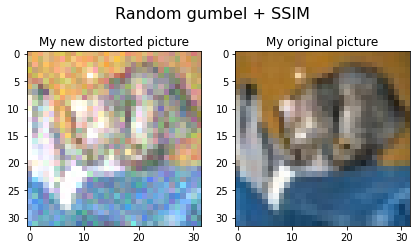

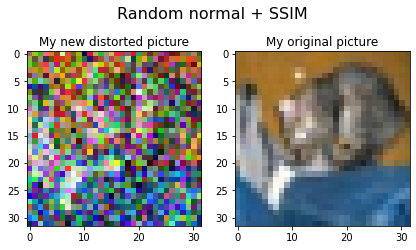

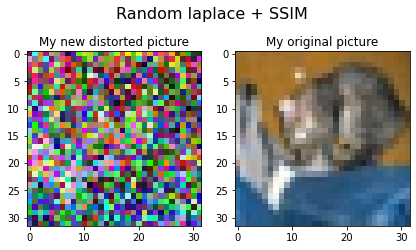

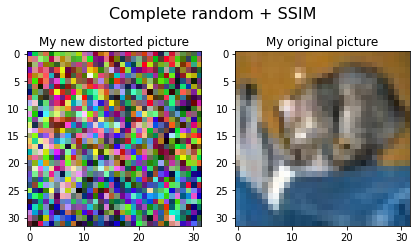

In [23]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

In [24]:
model_cifar_cnn = load_model("model_cifar_cnn.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 43
new ID: 6
old ID: 3
It took us 1.5740571022033691 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 70
new ID: 2
old ID: 3
It took us 2.277040481567383 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 30
new ID: 6
old ID: 3
It took us 1.0127558708190918 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 112
new ID: 6
old ID: 3
It took us 3.656306743621826 seconds
-------------------------------------------------------


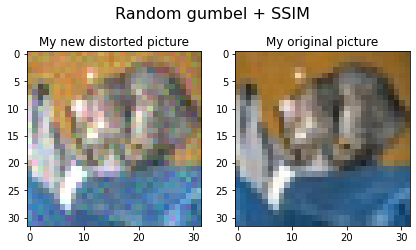

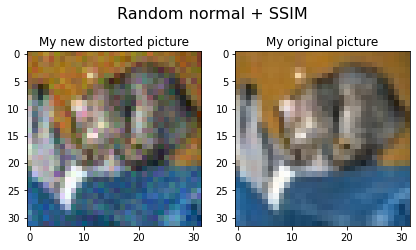

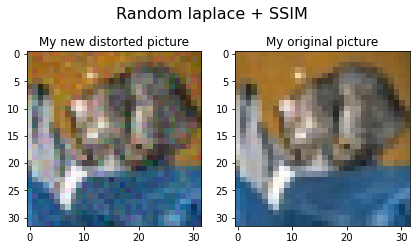

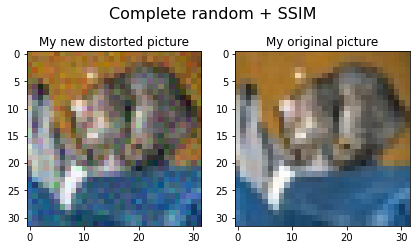

In [25]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

Gumbel random fuzzer + ISSM:


/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:163: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


We found it in iteration number 50
new ID: 2
old ID: 3
It took us 1.714890956878662 seconds
-------------------------------------------------------
Normal random fuzzer + ISSM:
We found it in iteration number 45
new ID: 6
old ID: 3
It took us 1.5525281429290771 seconds
-------------------------------------------------------
Laplace random fuzzer + ISSM:
We found it in iteration number 32
new ID: 2
old ID: 3
It took us 1.0926322937011719 seconds
-------------------------------------------------------
Compeletly random fuzzer + ISSM:
We found it in iteration number 107
new ID: 2
old ID: 3
It took us 3.5688459873199463 seconds
-------------------------------------------------------


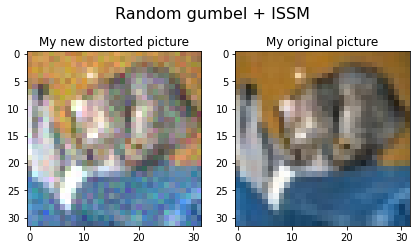

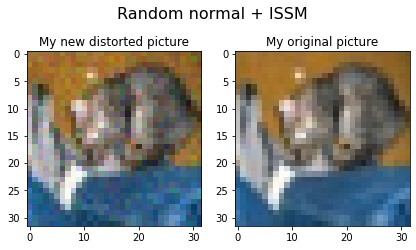

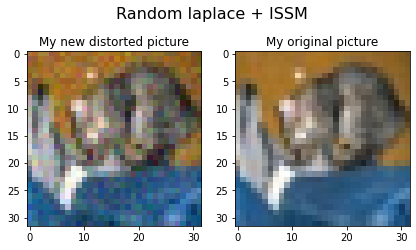

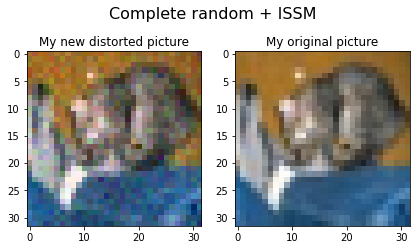

In [26]:
print("Gumbel random fuzzer + ISSM:")
myFuzz = gumbelRandomISSM(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + ISSM")
print("-------------------------------------------------------")
print("Normal random fuzzer + ISSM:")
myFuzz = normalRandomISSM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + ISSM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + ISSM:")
myFuzz = laplaceRandomISSM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + ISSM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + ISSM:")
myFuzz = CompeletlyRandomISSM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + ISSM")
print("-------------------------------------------------------")

In [27]:
model_cifar_ann = load_model("model_cifar_ann.h5")

Gumbel random fuzzer + ISSM:


/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:146: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan_to_num(H * np.log2(H)))
/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:163: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


We found it in iteration number 81
new ID: 5
old ID: 3
It took us 2.771245002746582 seconds
-------------------------------------------------------
Normal random fuzzer + ISSM:
We found it in iteration number 1959
new ID: 4
old ID: 3
It took us 63.806620597839355 seconds
-------------------------------------------------------
Laplace random fuzzer + ISSM:
We found it in iteration number 2591
new ID: 5
old ID: 3
It took us 84.32897305488586 seconds
-------------------------------------------------------
Compeletly random fuzzer + ISSM:
We found it in iteration number 1650
new ID: 4
old ID: 3
It took us 53.46082615852356 seconds
-------------------------------------------------------


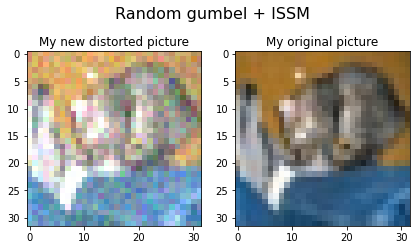

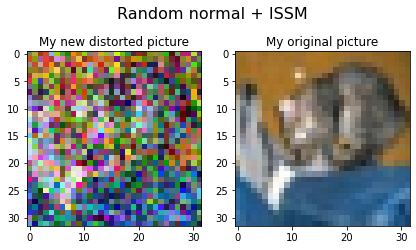

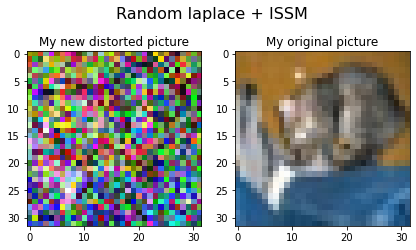

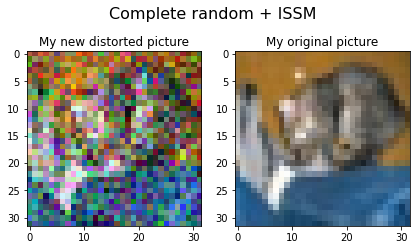

In [28]:
print("Gumbel random fuzzer + ISSM:")
myFuzz = gumbelRandomISSM(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + ISSM")
print("-------------------------------------------------------")
print("Normal random fuzzer + ISSM:")
myFuzz = normalRandomISSM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + ISSM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + ISSM:")
myFuzz = laplaceRandomISSM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + ISSM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + ISSM:")
myFuzz = CompeletlyRandomISSM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + ISSM")
print("-------------------------------------------------------")